<a href="https://colab.research.google.com/github/iskra3138/UDA/blob/main/office31_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Mar 19 14:30:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/tim-learn/SHOT.git

Cloning into 'SHOT'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 227 (delta 11), reused 15 (delta 6), pack-reused 203
Receiving objects: 100% (227/227), 489.24 KiB | 23.30 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [ ]:
cd SHOT/object/

/content/SHOT/object


### office31 dataset

In [ ]:
!gdown  https://drive.google.com/uc?id=0B4IapRTv9pJ1WGZVd1VDMmhwdlE

Downloading...
From: https://drive.google.com/uc?id=0B4IapRTv9pJ1WGZVd1VDMmhwdlE
To: /content/SHOT/object/domain_adaptation_images.tar.gz
77.2MB [00:00, 89.2MB/s]


In [ ]:
!tar -xvzf domain_adaptation_images.tar.gz

amazon/images/back_pack/frame_0001.jpg
amazon/images/back_pack/frame_0002.jpg
amazon/images/back_pack/frame_0003.jpg
amazon/images/back_pack/frame_0004.jpg
amazon/images/back_pack/frame_0005.jpg
amazon/images/back_pack/frame_0006.jpg
amazon/images/back_pack/frame_0007.jpg
amazon/images/back_pack/frame_0008.jpg
amazon/images/back_pack/frame_0009.jpg
amazon/images/back_pack/frame_0010.jpg
amazon/images/back_pack/frame_0011.jpg
amazon/images/back_pack/frame_0012.jpg
amazon/images/back_pack/frame_0013.jpg
amazon/images/back_pack/frame_0014.jpg
amazon/images/back_pack/frame_0015.jpg
amazon/images/back_pack/frame_0016.jpg
amazon/images/back_pack/frame_0017.jpg
amazon/images/back_pack/frame_0018.jpg
amazon/images/back_pack/frame_0019.jpg
amazon/images/back_pack/frame_0020.jpg
amazon/images/back_pack/frame_0021.jpg
amazon/images/back_pack/frame_0022.jpg
amazon/images/back_pack/frame_0023.jpg
amazon/images/back_pack/frame_0024.jpg
amazon/images/back_pack/frame_0025.jpg
amazon/images/back_pack/f

In [ ]:
ll

total 75504
drwxr-xr-x 3 root     4096 Mar 19 14:30 amazon/
-rw-r--r-- 1 root     2797 Mar 19 14:30 data_list.py
-rw-r--r-- 1 root 77187046 Mar 19 14:30 domain_adaptation_images.tar.gz
drwxr-xr-x 3 root     4096 Mar 19 14:30 dslr/
-rw-r--r-- 1 root     9903 Mar 19 14:30 image_multisource.py
-rw-r--r-- 1 root    14024 Mar 19 14:30 image_multitarget.py
-rw-r--r-- 1 root    11369 Mar 19 14:30 image_pretrained.py
-rw-r--r-- 1 root    16232 Mar 19 14:30 image_source.py
-rw-r--r-- 1 root    16393 Mar 19 14:30 image_target_oda.py
-rw-r--r-- 1 root    15741 Mar 19 14:30 image_target.py
-rw-r--r-- 1 root     3361 Mar 19 14:30 loss.py
-rw-r--r-- 1 root     5193 Mar 19 14:30 network.py
-rw-r--r-- 1 root     3312 Mar 19 14:30 run.sh
drwxr-xr-x 3 root     4096 Mar 19 14:30 webcam/


# Modifying 

### Making files about paths of images
- ref: https://github.com/tim-learn/SHOT/issues/2

In [ ]:
import os, glob 
data_path = './data/office'
if not os.path.exists(data_path) :
  os.makedirs(data_path)

datasets = ['amazon', 'dslr', 'webcam']
classes = os.listdir('./amazon/images/')

for dataset in datasets:
  img_paths_file = open(os.path.join(data_path,'{}_list.txt'.format(dataset)), 'w')
  for i, cls in enumerate(classes): 
    for filename in glob.glob(os.path.join(dataset,'images',cls,'*.jpg')):
      img_paths_file.write("{} {}\n".format(filename,i))
  img_paths_file.close()

In [ ]:
### you can download txt files to check them.
#from google.colab import files
#files.download('./data/office/amazon_list.txt')
#files.download('./data/office/dslr_list.txt')
#files.download('./data/office/webcam_list.txt')

In [ ]:
NUM_WORKERS = 2
BATCHSIZE = 64
folder = './data/'
names = ['amazon', 'dslr', 'webcam']
CLASS_NUM = 31
SOURCE = names[1]
TARGET = names[0]
TRTE = 'val'
DSET = 'office'
NET = 'resnet50'
MAX_EPOCH=100

NAME_SRC = SOURCE[0].upper()

S_DSET_PATH = folder + DSET + '/' + '{}_list.txt'.format(SOURCE)
TEST_DSET_PATH = folder + DSET + '/' + '{}_list.txt'.format(TARGET)

In [ ]:
import argparse
import os, sys
import os.path as osp
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import network, loss
from torch.utils.data import DataLoader
from data_list import ImageList
import random, pdb, math, copy
from tqdm import tqdm
from loss import CrossEntropyLabelSmooth
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans


def image_train(resize_size=256, crop_size=224, alexnet=False):
  if not alexnet:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  else:
    normalize = Normalize(meanfile='./ilsvrc_2012_mean.npy')
  return  transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

def image_test(resize_size=256, crop_size=224, alexnet=False):
  if not alexnet:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  else:
    normalize = Normalize(meanfile='./ilsvrc_2012_mean.npy')
  return  transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        normalize
    ])
  
def data_load(): 
    ## prepare data
    dsets = {}
    dset_loaders = {}
    train_bs = BATCHSIZE
    txt_src = open(S_DSET_PATH).readlines()
    txt_test = open(TEST_DSET_PATH).readlines()

    if TRTE == "val":
        dsize = len(txt_src)
        tr_size = int(0.9*dsize)
        # print(dsize, tr_size, dsize - tr_size)
        tr_txt, te_txt = torch.utils.data.random_split(txt_src, [tr_size, dsize - tr_size])
    else:
        dsize = len(txt_src)
        tr_size = int(0.9*dsize)
        _, te_txt = torch.utils.data.random_split(txt_src, [tr_size, dsize - tr_size])
        tr_txt = txt_src

    dsets["source_tr"] = ImageList(tr_txt, transform=image_train())
    dset_loaders["source_tr"] = DataLoader(dsets["source_tr"], batch_size=train_bs, shuffle=True, num_workers=NUM_WORKERS, drop_last=False)
    dsets["source_te"] = ImageList(te_txt, transform=image_test())
    dset_loaders["source_te"] = DataLoader(dsets["source_te"], batch_size=train_bs, shuffle=True, num_workers=NUM_WORKERS, drop_last=False)
    dsets["test"] = ImageList(txt_test, transform=image_test())
    dset_loaders["test"] = DataLoader(dsets["test"], batch_size=train_bs*2, shuffle=True, num_workers=NUM_WORKERS, drop_last=False)

    return dset_loaders


In [ ]:
dset_loaders = data_load()

acc_init = 0
max_iter = MAX_EPOCH * len(dset_loaders["source_tr"])
interval_iter = max_iter // 10
iter_num = 0

In [ ]:
import re, sys, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
IMAGE_SIZE = (224,224)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


In [ ]:
def create_model():
    pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.ResNet50(include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True
    
    x = pretrained_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, name='feature') (x)  
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.ReLU()(x)  
    #x = tf.keras.layers.Dropout(rate=0.5)(x)
    predictions = tf.keras.layers.Dense(31, activation='softmax', name='prediction') (x)
    #predictions = tf.keras.layers.Dense(31, name='prediction') (x)
    model = tf.keras.Model(inputs=pretrained_model.input, outputs=predictions)

    return model

In [ ]:
model = create_model()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
model.losses

[]

In [ ]:
# adding L2 regularizer (https://sthalles.github.io/keras-regularizer/)
import os
import tempfile

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
model = add_regularization(model)

In [ ]:
model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.11616695>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.021069562>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0339693>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.05057001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.025638832>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.019488763>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.038293593>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.022783704>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.020211041>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.036940254>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.021386005>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.029886987>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07406923>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.093878016>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.05633305>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.036226183>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06651061>,
 <tf.Tensor: shape=()

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
@keras_export("keras.optimizers.schedules.ExponentialDecay")
class lr_Decay(tf.keras.optimizers.schedules.):
  """A LearningRateSchedule that uses an exponential decay schedule.
  When training a model, it is often recommended to lower the learning rate as
  the training progresses. This schedule applies an exponential decay function
  to an optimizer step, given a provided initial learning rate.
  The schedule a 1-arg callable that produces a decayed learning
  rate when passed the current optimizer step. This can be useful for changing
  the learning rate value across different invocations of optimizer functions.
  It is computed as:
  ```python
  def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ^ (step / decay_steps)
  ```
  If the argument `staircase` is `True`, then `step / decay_steps` is
  an integer division and the decayed learning rate follows a
  staircase function.
  You can pass this schedule directly into a `tf.keras.optimizers.Optimizer`
  as the learning rate.
  Example: When fitting a Keras model, decay every 100000 steps with a base
  of 0.96:
  ```python
  initial_learning_rate = 0.1
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(data, labels, epochs=5)
  ```
  The learning rate schedule is also serializable and deserializable using
  `tf.keras.optimizers.schedules.serialize` and
  `tf.keras.optimizers.schedules.deserialize`.
  Returns:
    A 1-arg callable learning rate schedule that takes the current optimizer
    step and outputs the decayed learning rate, a scalar `Tensor` of the same
    type as `initial_learning_rate`.
  """

  def __init__(
      self,
      initial_learning_rate,
      max_iter,
      gamma=10,
      power=0.75,
      name=None):
    """Applies exponential decay to the learning rate.
    Args:
      initial_learning_rate: A scalar `float32` or `float64` `Tensor` or a
        Python number.  The initial learning rate.
      decay_steps: A scalar `int32` or `int64` `Tensor` or a Python number.
        Must be positive.  See the decay computation above.
      decay_rate: A scalar `float32` or `float64` `Tensor` or a
        Python number.  The decay rate.
      staircase: Boolean.  If `True` decay the learning rate at discrete
        intervals
      name: String.  Optional name of the operation.  Defaults to
        'ExponentialDecay'.
    """
    super(lrDecay, self).__init__()
    self.initial_learning_rate = initial_learning_rate
    self.max_iter = max_iter
    self.gamma = gamma
    self.power = power
    self.name = name

  def __call__(self, step):
    with ops.name_scope_v2(self.name or "lrDecay") as name:
      initial_learning_rate = ops.convert_to_tensor_v2_with_dispatch(
          self.initial_learning_rate, name="initial_learning_rate")
      dtype = initial_learning_rate.dtype
      max_iter = math_ops.cast(self.max_iter, dtype)
      gamma = math_ops.cast(self.gamma, dtype)
      power = math_ops.cast(self.power, dtype)

      #global_step_recomp = math_ops.cast(step, dtype)
      #p = global_step_recomp / decay_steps
      #if self.staircase:
      #  p = math_ops.floor(p)
      return math_ops.multiply(
          initial_learning_rate, math_ops.pow(decay_rate, p), name=name)

  def get_config(self):
    return {
        "initial_learning_rate": self.initial_learning_rate,
        "decay_steps": self.decay_steps,
        "decay_rate": self.decay_rate,
        "staircase": self.staircase,
        "name": self.name
    }

In [ ]:
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, )
loss_object = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
#optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

initial_learning_rate = 0.1
lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer1 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  variable_list1 =[]
  variable_list2 =[]

  for var in model.trainable_variables:
    if 'conv' in var.name :
      variable_list1.append(var)
    else:
      variable_list2.append(var)

  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    labels = tf.one_hot(labels, 31)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  grads_one = gradients[:len(variable_list1)]
  grads_two = gradients[len(variable_list1):]
  train_op1 = optimizer1.apply_gradients(zip(grads_one, variable_list1))
  train_op2 = optimizer1.apply_gradients(zip(grads_two, variable_list2))

  train_op = tf.group(train_op1, train_op2)

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  labels = tf.one_hot(labels, 31)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
for epoch in range(100):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  iter_source = iter(dset_loaders["source_tr"])
  for i, _ in enumerate(dset_loaders["source_tr"]):
    inputs_source, labels_source = iter_source.next()
    inputs_source = inputs_source.permute(0, 2, 3, 1)
    train_step(inputs_source.numpy(), labels_source.numpy())

  if (epoch+1) % 10 == 0 :
    iter_source = iter(dset_loaders["test"])
    for i, _ in enumerate(dset_loaders["test"]):
      inputs_source, labels_source = iter_source.next()
      inputs_source = inputs_source.permute(0, 2, 3, 1)
      test_step(inputs_source.numpy(), labels_source.numpy())

    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss.result()}, '  
      f'Accuracy: {train_accuracy.result() * 100}, '  
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 10, Loss: 0.6798849105834961, Accuracy: 100.0, Test Loss: 4.094531059265137, Test Accuracy: 3.8338656425476074
Epoch 20, Loss: 0.6733946204185486, Accuracy: 100.0, Test Loss: 3.8495514392852783, Test Accuracy: 5.963791370391846
Epoch 30, Loss: 0.6756938099861145, Accuracy: 100.0, Test Loss: 3.6578786373138428, Test Accuracy: 9.478168487548828
Epoch 40, Loss: 0.6791243553161621, Accuracy: 100.0, Test Loss: 3.37384033203125, Test Accuracy: 13.063542366027832
Epoch 50, Loss: 0.6744632720947266, Accuracy: 100.0, Test Loss: 3.2498323917388916, Test Accuracy: 16.506921768188477
Epoch 60, Loss: 0.6722522377967834, Accuracy: 100.0, Test Loss: 3.1263670921325684, Test Accuracy: 21.618743896484375
Epoch 70, Loss: 0.6751720309257507, Accuracy: 100.0, Test Loss: 3.011885643005371, Test Accuracy: 24.60063934326172
Epoch 80, Loss: 0.6836181282997131, Accuracy: 100.0, Test Loss: 3.0371458530426025, Test Accuracy: 26.411073684692383
Epoch 90, Loss: 0.6733198165893555, Accuracy: 100.0, Test Loss:

# Delete

In [ ]:
max_iter

700

In [ ]:
iter_source = iter(dset_loaders["test"])
total = 0
for i, _ in enumerate(dset_loaders["test"]):
  #for i in range(len(loader)):  
  image, label = iter_source.next()
  total += label.shape[0]
  print (label.shape[0])

In [ ]:
iter_num = 0
while iter_num < max_iter: 
    iter_source = iter(dset_loaders["source_tr"])
    inputs_source, labels_source = iter_source.next()
    inputs_source = inputs_source.permute(0, 2, 3, 1)
    
    if inputs_source.size(0) == 1:
        continue

    iter_num += 1
    #lr_scheduler(optimizer, iter_num=iter_num, max_iter=max_iter)
    inputs_source = inputs_source.numpy()
    labels_source = labels_source.numpy()
    train_step(inputs_source, labels_source)


    if iter_num % interval_iter == 0 or iter_num == max_iter:
        test_iter_source = iter(dset_loaders["test"])
        total = 0
        for i, _ in enumerate(dset_loaders["test"]):
            test_images, test_labels = test_iter_source.next()
            test_images = test_images.permute(0, 2, 3, 1)

            test_images = test_images.numpy()
            test_labels = test_labels.numpy
            test_step(test_images, test_labels)
            
        '''
        if acc_s_te >= acc_init:
            acc_init = acc_s_te
            best_netF = netF.state_dict()
            best_netB = netB.state_dict()
            best_netC = netC.state_dict()
        '''

TypeError: ignored

In [ ]:
variable_list1 = [variables from first 6 layers]

variable_list2 = [the rest of variables]

op1 = tf.train.GradientDescentOptimizer(0.00002)

op2 = tf.train.GradientDescentOptimizer(0.0002)

grads = tf.gradients(loss, variable_list1 + variable_list2)

grads_one = grads[:len(variable_list1)]

grads_two = grads[len(variable_list1):]

train_op1 = op1.apply_gradients(zip(grads_one, variable_list1))

train_op2 = op2.apply_gradients(zip(grads_two, variable_list2))

train_op = tf.group(train_op1, train_op2)

In [ ]:
 
 x.shape

torch.Size([64, 224, 224, 3])

# Training

In [ ]:
import re, sys, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])

elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)

else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

Running on single GPU  /physical_device:GPU:0


In [ ]:
IMAGE_SIZE = [224, 224]
#CLASSES
EPOCHS = 100
BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 64
start_lr = 0.01
#min_lr = 0.00001
#max_lr = 0.005
#rampup_epochs = 5
#sustain_epochs = 0
#exp_decay = .8

0.01 0.0016669789914299244


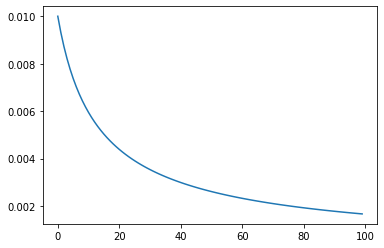

In [ ]:
def lrfn(epoch):
    lr = start_lr * ((1+10*(epoch/EPOCHS))**-0.75)
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [ ]:
'''
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])
'''

'\ndef lrfn(epoch):\n    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):\n        if epoch < rampup_epochs:\n            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr\n        elif epoch < rampup_epochs + sustain_epochs:\n            lr = max_lr\n        else:\n            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr\n        return lr\n    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)\n    \nlr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)\n\nrng = [i for i in range(EPOCHS)]\ny = [lrfn(x) for x in rng]\nplt.plot(rng, [lrfn(x) for x in rng])\nprint(y[0], y[-1])\n'

In [ ]:
ll

total 156528
drwxr-xr-x 3 root     4096 Mar 18 14:40 amazon/
-rw-r--r-- 1 root 24365355 Mar 18 14:41 amazon-00-2817.tfrec
-rw-r--r-- 1 root 77187046 Mar 18 14:40 domain_adaptation_images.tar.gz
drwxr-xr-x 3 root     4096 Mar 18 14:40 dslr/
-rw-r--r-- 1 root 37450804 Mar 18 14:41 dslr-00-498.tfrec
drwxr-xr-x 1 root     4096 Mar  5 14:37 sample_data/
drwxr-xr-x 3 root     4096 Mar 18 14:40 webcam/
-rw-r--r-- 1 root 21254986 Mar 18 14:41 webcam-00-795.tfrec


In [ ]:
# tfrecord이름에 포함된 파일 개수 counting하는 함수
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

TRAIN_FILENAMES = tf.io.gfile.glob('./dslr*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob('./amazon*.tfrec')

# Keras로 학습할 때 필요한 train_steps 계산
TRAIN_STEPS = count_data_items(TRAIN_FILENAMES) // BATCH_SIZE
print("TRAINING IMAGES: ", count_data_items(TRAIN_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALID_FILENAMES))

TRAINING IMAGES:  498 , STEPS PER EPOCH:  7
VALIDATION IMAGES:  2817


## training and validation datasets

TFRecord 파일 기반 DataSet 생성

In [ ]:
## TFRecord 파일 Parsing 
#### TFRecord 생성 코드 참고해서 정의함
#### TFRecord에 포함된 데이터들 중 필요한 것들만 Return
TARGET_SIZE = (256,256)
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        #"one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) ## make [0,255] to [0,1) resize 앞에 위치할 때만 [0,1), 즉 input이 float32가 아니어야 작동
    image = tf.image.resize(image, TARGET_SIZE) ## method가 tf.image.ResizeMethod.NEAREST_NEIGHBOR 가 아니면 출력은 무조건 float32

    class_label = tf.cast(example['label'], tf.int32)
    #one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    #one_hot_class = tf.reshape(one_hot_class, [31])
    one_hot_class = tf.one_hot(class_label, 31)
    return image, one_hot_class
  
def force_image_sizes(dataset, image_size):
    # explicit size will be needed for TPU
    reshape_images = lambda image, label: (tf.reshape(image, [*image_size, 3]), label)
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    #dataset = force_image_sizes(dataset, IMAGE_SIZE)
    return dataset

def data_augment(image, one_hot_class):
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    return image, one_hot_class

def center_crop(image, one_hot_class):
    image = tf.image.central_crop(image, central_fraction=0.875)
    return image, one_hot_class

def make_NCHW(image, one_hot_class):
    image = tf.transpose(image, [2, 0, 1]) # HWC -> CHW
    return image, one_hot_class  

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    #dataset = dataset.map(make_NCHW, num_parallel_calls=AUTO)
    #dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES)
    dataset = dataset.map(center_crop, num_parallel_calls=AUTO)
    #dataset = dataset.map(make_NCHW, num_parallel_calls=AUTO)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    opt = tf.data.Options()
    opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    dataset = dataset.with_options(opt)
    
    return dataset

In [ ]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in training_dataset:
    train_step(images, labels)

  for test_images, test_labels in validation_dataset:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 1.3133447170257568, Accuracy: 69.27710723876953, Test Loss: 7.149159908294678, Test Accuracy: 5.076322555541992
Epoch 2, Loss: 0.5712549686431885, Accuracy: 83.73493957519531, Test Loss: 94.66526794433594, Test Accuracy: 3.5498757362365723
Epoch 3, Loss: 0.5360175371170044, Accuracy: 89.35742950439453, Test Loss: 118.99026489257812, Test Accuracy: 1.2779552936553955
Epoch 4, Loss: 0.2810366749763489, Accuracy: 92.57028198242188, Test Loss: 20.3486328125, Test Accuracy: 3.336883306503296
Epoch 5, Loss: 0.1372235119342804, Accuracy: 96.58634948730469, Test Loss: 24.069053649902344, Test Accuracy: 3.5498757362365723
Epoch 6, Loss: 0.1591532975435257, Accuracy: 96.18473815917969, Test Loss: 23.113039016723633, Test Accuracy: 3.5498757362365723
Epoch 7, Loss: 0.06520082801580429, Accuracy: 98.99598693847656, Test Loss: 15.691036224365234, Test Accuracy: 3.5498757362365723
Epoch 8, Loss: 0.03427233174443245, Accuracy: 99.39759063720703, Test Loss: 12.251653671264648, Test Accu

KeyboardInterrupt: ignored

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in training_dataset:
    train_step(images, labels)

  for test_images, test_labels in validation_dataset:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 2.0674784183502197, Accuracy: 48.79518127441406, Test Loss: 4.523988723754883, Test Accuracy: 3.301384210586548
Epoch 2, Loss: 0.644093930721283, Accuracy: 85.34136199951172, Test Loss: 5.851849555969238, Test Accuracy: 4.792332172393799
Epoch 3, Loss: 0.3105000853538513, Accuracy: 93.77510070800781, Test Loss: 6.211411476135254, Test Accuracy: 3.301384210586548
Epoch 4, Loss: 0.17681226134300232, Accuracy: 97.18875122070312, Test Loss: 6.101815223693848, Test Accuracy: 3.301384210586548
Epoch 5, Loss: 0.1061072051525116, Accuracy: 98.39356994628906, Test Loss: 8.992409706115723, Test Accuracy: 1.2779552936553955
Epoch 6, Loss: 0.08481092751026154, Accuracy: 98.99598693847656, Test Loss: 6.975498676300049, Test Accuracy: 1.2779552936553955
Epoch 7, Loss: 0.0979708880186081, Accuracy: 98.1927719116211, Test Loss: 5.811068534851074, Test Accuracy: 1.2779552936553955
Epoch 8, Loss: 0.03950268775224686, Accuracy: 100.0, Test Loss: 4.962959289550781, Test Accuracy: 3.33688330

In [ ]:
import os 

model_dir = './'
ckpt_full_path = os.path.join(model_dir, 'model.ckpt-{epoch:04d}')
callbacks = [
    lr_callback,
    tf.keras.callbacks.TensorBoard(log_dir = model_dir),
    #tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_full_path,
    #                                   save_weights_only=True),
]

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print ('BATCH_SIZE: ', BATCH_SIZE)
start_time = time.time()
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=callbacks)
#history = model.fit(training_dataset, validation_data=validation_dataset,
#                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

In [ ]:
save_model = create_model()
save_model.set_weights(model.get_weights())
save_model.save('office31_resnet50_dslr.h5')

In [ ]:
from google.colab import files

files.download('office31_resnet50_dslr.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
variable_list1 = [variables from first 6 layers]
variable_list2 = [the rest of variables]

op1 = tf.train.GradientDescentOptimizer(0.00002)
op2 = tf.train.GradientDescentOptimizer(0.0002)

grads = tf.gradients(loss, variable_list1 + variable_list2)

grads_one = grads[:len(variable_list1)]
grads_two = grads[len(variable_list1):]

train_op1 = op1.apply_gradients(zip(grads_one, variable_list1))
train_op2 = op2.apply_gradients(zip(grads_two, variable_list2))

train_op = tf.group(train_op1, train_op2)

In [ ]:
#https://www.tensorflow.org/tutorials/quickstart/advanced
#https://intellipaat.com/community/495/how-to-set-layer-wise-learning-rate-in-tensorflow


### Changing a default folder to folder in which the image paths files are located

In [ ]:
import sys, fileinput
File = '/content/SHOT/object/image_source.py'
Replace_What = '/Checkpoint/liangjian/tran/data/'
New_Value = './data/'
for Line in fileinput.input(File, inplace=True):  #:- Entire Line Replace
    if Replace_What in Line:
        Line = Line.replace(Replace_What, New_Value)
    sys.stdout.write(Line)

#PyTorch 학습

In [ ]:
import argparse
import os, sys
import os.path as osp
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import network, loss
from torch.utils.data import DataLoader
from data_list import ImageList
import random, pdb, math, copy
from tqdm import tqdm
from loss import CrossEntropyLabelSmooth
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

def op_copy(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr0'] = param_group['lr']
    return optimizer

def lr_scheduler(optimizer, iter_num, max_iter, gamma=10, power=0.75):
    decay = (1 + gamma * iter_num / max_iter) ** (-power)
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr0'] * decay
        param_group['weight_decay'] = 1e-3
        param_group['momentum'] = 0.9
        param_group['nesterov'] = True
    return optimizer

def image_train(resize_size=256, crop_size=224, alexnet=False):
  if not alexnet:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  else:
    normalize = Normalize(meanfile='./ilsvrc_2012_mean.npy')
  return  transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

def image_test(resize_size=256, crop_size=224, alexnet=False):
  if not alexnet:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  else:
    normalize = Normalize(meanfile='./ilsvrc_2012_mean.npy')
  return  transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        normalize
    ])

In [ ]:
#"image": _bytestring_feature([img_bytes]), # one image in the list
#"file_name": _bytestring_feature([file_name]),     # fixed length (1) list of strings, the text label
#"label_name": _bytestring_feature([label_name]),     # fixed length (1) list of strings, the text label
#"label": _int_feature([label]),     # fixed length (1) list of strings, the text label

In [ ]:
ll

total 156640
drwxr-xr-x 3 root     4096 Mar 19 04:56 amazon/
-rw-r--r-- 1 root 24365355 Mar 19 04:56 amazon-00-2817.tfrec
-rw-r--r-- 1 root     2797 Mar 19 04:54 data_list.py
-rw-r--r-- 1 root 77187046 Mar 19 04:56 domain_adaptation_images.tar.gz
drwxr-xr-x 3 root     4096 Mar 19 04:56 dslr/
-rw-r--r-- 1 root 37450804 Mar 19 04:56 dslr-00-498.tfrec
-rw-r--r-- 1 root     9903 Mar 19 04:54 image_multisource.py
-rw-r--r-- 1 root    14024 Mar 19 04:54 image_multitarget.py
-rw-r--r-- 1 root    11369 Mar 19 04:54 image_pretrained.py
-rw-r--r-- 1 root    16232 Mar 19 04:54 image_source.py
-rw-r--r-- 1 root    16393 Mar 19 04:54 image_target_oda.py
-rw-r--r-- 1 root    15741 Mar 19 04:54 image_target.py
-rw-r--r-- 1 root     3361 Mar 19 04:54 loss.py
-rw-r--r-- 1 root     5193 Mar 19 04:54 network.py
drwxr-xr-x 2 root     4096 Mar 19 04:56 __pycache__/
-rw-r--r-- 1 root     3312 Mar 19 04:54 run.sh
drwxr-xr-x 3 root     4096 Mar 19 04:56 webcam/
-rw-r--r-- 1 root 21254986 Mar 19 04:56 webcam-0

In [ ]:
import tfrecord
import cv2

def decode_train_image(features):
    # get BGR image from bytes
    image = cv2.imdecode(features["image"], -1)
    #features["image"] = tf.image.decode_jpeg(features["image"], channels=3).numpy()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    image = transforms.ToTensor()(image)
    image  = transforms.Resize((256, 256))(image)
    image = transforms.RandomCrop(224)(image)
    image = transforms.RandomHorizontalFlip()(image)
    
    image = normalize(image)

    #y = torch.eye(31) 
    #label = y[features['label']][0]
    label = np.int64(features['label'][0])
    return image, label

def decode_test_image(features):
    # get BGR image from bytes
    image = cv2.imdecode(features["image"], -1)
    #features["image"] = tf.image.decode_jpeg(features["image"], channels=3).numpy()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    image = transforms.ToTensor()(image)
    image  = transforms.Resize((256, 256))(image)
    image = transforms.CenterCrop(224)(image)
    
    image = normalize(image)

    #y = torch.eye(31) 
    #label = y[features['label']][0]
    label = np.int64(features['label'][0])
    return image, label

description = {
    "image": "byte", 
    "label": "int"
}

dataset = tfrecord.torch.TFRecordDataset("./dslr-00-498.tfrec",
                                         index_path=None,
                                         description=description,
                                         transform=decode_train_image)
dataset = torch.utils.data.DataLoader(dataset, batch_size=64, drop_last=False)
image, label = next(iter(dataset))
print(label.shape)
print (image.shape)


torch.Size([64])
torch.Size([64, 3, 224, 224])


In [ ]:
label

tensor([ 7, 26, 22,  0, 22, 17, 17,  0,  4, 29, 25, 22,  2,  2,  0, 29,  9, 13,
         4,  4,  5, 21,  8, 21, 10,  4, 22,  3,  0, 27,  3,  3,  4,  0, 29, 27,
         4, 24, 17, 30, 23,  4,  0,  4, 15,  1, 10, 13, 22, 25, 15, 23,  1,  6,
         5, 19,  6, 10,  8, 14,  4, 29,  2,  4])

In [ ]:
import torch
from tfrecord.torch.dataset import TFRecordDataset
dset_loaders = {}

train_tfrecord_path = "./dslr-00-498.tfrec"
test_tfrecord_path = "./amazon-00-2817.tfrec"
index_path = None
description = {
    "image": "byte", 
    "label": "int"
}
dataset = tfrecord.torch.TFRecordDataset("./dslr-00-498.tfrec",
                                         index_path=None,
                                         description=description,
                                         transform=decode_test_image)
dataset = torch.utils.data.DataLoader(dataset, batch_size=64, drop_last=False)

dataset = TFRecordDataset(train_tfrecord_path, index_path, description, transform=decode_train_image)
dset_loaders["source_tr"] = torch.utils.data.DataLoader(dataset, batch_size=64, drop_last=False)

dataset = TFRecordDataset(test_tfrecord_path, index_path, description, transform=decode_test_image)
dset_loaders["test"] = torch.utils.data.DataLoader(dataset, batch_size=128, drop_last=False)

In [ ]:
image, label = next(iter(dset_loaders["test"]))
print(label.shape)
print (image.shape)

torch.Size([128])
torch.Size([128, 3, 224, 224])


In [ ]:
def cal_acc(loader, netF, netB, netC, flag=False):
    start_test = True
    with torch.no_grad():
        iter_test = iter(loader)
        for i, _ in enumerate(loader):
        #for i in range(len(loader)):  
            data = iter_test.next()
            inputs = data[0]
            labels = data[1]
            inputs = inputs.cuda()
            outputs = netC(netB(netF(inputs)))
            if start_test:
                all_output = outputs.float().cpu()
                all_label = labels.float()
                start_test = False
            else:
                all_output = torch.cat((all_output, outputs.float().cpu()), 0)
                all_label = torch.cat((all_label, labels.float()), 0)

    all_output = nn.Softmax(dim=1)(all_output)
    _, predict = torch.max(all_output, 1)
    accuracy = torch.sum(torch.squeeze(predict).float() == all_label).item() / float(all_label.size()[0])
    mean_ent = torch.mean(loss.Entropy(all_output)).cpu().data.item()
   
    if flag:
        matrix = confusion_matrix(all_label, torch.squeeze(predict).float())
        acc = matrix.diagonal()/matrix.sum(axis=1) * 100
        aacc = acc.mean()
        aa = [str(np.round(i, 2)) for i in acc]
        acc = ' '.join(aa)
        return aacc, acc
    else:
        return accuracy*100, mean_ent

def cal_acc_oda(loader, netF, netB, netC):
    start_test = True
    with torch.no_grad():
        iter_test = iter(loader)
        for i in range(len(loader)):
            data = iter_test.next()
            inputs = data[0]
            labels = data[1]
            inputs = inputs.cuda()
            outputs = netC(netB(netF(inputs)))
            if start_test:
                all_output = outputs.float().cpu()
                all_label = labels.float()
                start_test = False
            else:
                all_output = torch.cat((all_output, outputs.float().cpu()), 0)
                all_label = torch.cat((all_label, labels.float()), 0)

    all_output = nn.Softmax(dim=1)(all_output)
    _, predict = torch.max(all_output, 1)
    ent = torch.sum(-all_output * torch.log(all_output + args.epsilon), dim=1) / np.log(args.class_num)
    ent = ent.float().cpu()
    initc = np.array([[0], [1]])
    kmeans = KMeans(n_clusters=2, random_state=0, init=initc, n_init=1).fit(ent.reshape(-1,1))
    threshold = (kmeans.cluster_centers_).mean()

    predict[ent>threshold] = args.class_num
    matrix = confusion_matrix(all_label, torch.squeeze(predict).float())
    matrix = matrix[np.unique(all_label).astype(int),:]

    acc = matrix.diagonal()/matrix.sum(axis=1) * 100
    unknown_acc = acc[-1:].item()

    return np.mean(acc[:-1]), np.mean(acc), unknown_acc
    # return np.mean(acc), np.mean(acc[:-1])

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import math
import torch.nn.utils.weight_norm as weightNorm
from collections import OrderedDict

def calc_coeff(iter_num, high=1.0, low=0.0, alpha=10.0, max_iter=10000.0):
    return np.float(2.0 * (high - low) / (1.0 + np.exp(-alpha*iter_num / max_iter)) - (high - low) + low)

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

vgg_dict = {"vgg11":models.vgg11, "vgg13":models.vgg13, "vgg16":models.vgg16, "vgg19":models.vgg19, 
"vgg11bn":models.vgg11_bn, "vgg13bn":models.vgg13_bn, "vgg16bn":models.vgg16_bn, "vgg19bn":models.vgg19_bn} 
class VGGBase(nn.Module):
  def __init__(self, vgg_name):
    super(VGGBase, self).__init__()
    model_vgg = vgg_dict[vgg_name](pretrained=True)
    self.features = model_vgg.features
    self.classifier = nn.Sequential()
    for i in range(6):
        self.classifier.add_module("classifier"+str(i), model_vgg.classifier[i])
    self.in_features = model_vgg.classifier[6].in_features

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

res_dict = {"resnet18":models.resnet18, "resnet34":models.resnet34, "resnet50":models.resnet50, 
"resnet101":models.resnet101, "resnet152":models.resnet152, "resnext50":models.resnext50_32x4d, "resnext101":models.resnext101_32x8d}

class ResBase(nn.Module):
    def __init__(self, res_name):
        super(ResBase, self).__init__()
        model_resnet = res_dict[res_name](pretrained=True)
        self.conv1 = model_resnet.conv1
        self.bn1 = model_resnet.bn1
        self.relu = model_resnet.relu
        self.maxpool = model_resnet.maxpool
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3
        self.layer4 = model_resnet.layer4
        self.avgpool = model_resnet.avgpool
        self.in_features = model_resnet.fc.in_features

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class feat_bootleneck(nn.Module):
    def __init__(self, feature_dim, bottleneck_dim=256, type="ori"):
        super(feat_bootleneck, self).__init__()
        self.bn = nn.BatchNorm1d(bottleneck_dim, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.bottleneck = nn.Linear(feature_dim, bottleneck_dim)
        self.bottleneck.apply(init_weights)
        self.type = type

    def forward(self, x):
        x = self.bottleneck(x)
        if self.type == "bn":
            x = self.bn(x)
        return x

class feat_classifier(nn.Module):
    def __init__(self, class_num, bottleneck_dim=256, type="linear"):
        super(feat_classifier, self).__init__()
        self.type = type
        if type == 'wn':
            self.fc = weightNorm(nn.Linear(bottleneck_dim, class_num), name="weight")
            self.fc.apply(init_weights)
        else:
            self.fc = nn.Linear(bottleneck_dim, class_num)
            self.fc.apply(init_weights)

    def forward(self, x):
        x = self.fc(x)
        return x

class feat_classifier_two(nn.Module):
    def __init__(self, class_num, input_dim, bottleneck_dim=256):
        super(feat_classifier_two, self).__init__()
        self.type = type
        self.fc0 = nn.Linear(input_dim, bottleneck_dim)
        self.fc0.apply(init_weights)
        self.fc1 = nn.Linear(bottleneck_dim, class_num)
        self.fc1.apply(init_weights)

    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        return x

class Res50(nn.Module):
    def __init__(self):
        super(Res50, self).__init__()
        model_resnet = models.resnet50(pretrained=True)
        self.conv1 = model_resnet.conv1
        self.bn1 = model_resnet.bn1
        self.relu = model_resnet.relu
        self.maxpool = model_resnet.maxpool
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3
        self.layer4 = model_resnet.layer4
        self.avgpool = model_resnet.avgpool
        self.in_features = model_resnet.fc.in_features
        self.fc = model_resnet.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        y = self.fc(x)
        return x, y

In [ ]:
netF = ResBase(res_name='resnet50').cuda()
netB = feat_bootleneck(type="wn", feature_dim=netF.in_features, bottleneck_dim=256).cuda()
netC = feat_classifier(type="bn", class_num = 31, bottleneck_dim=256).cuda()

In [ ]:
param_group = []
learning_rate = 0.01
for k, v in netF.named_parameters():
    param_group += [{'params': v, 'lr': learning_rate*0.1}]
for k, v in netB.named_parameters():
    param_group += [{'params': v, 'lr': learning_rate}]
for k, v in netC.named_parameters():
    param_group += [{'params': v, 'lr': learning_rate}]   
optimizer = optim.SGD(param_group)
optimizer = op_copy(optimizer)

In [ ]:
acc_init = 0
max_iter = 100 * 7
interval_iter = max_iter // 10
iter_num = 0

netF.train()
netB.train()
netC.train()

feat_classifier(
  (fc): Linear(in_features=256, out_features=31, bias=True)
)

In [ ]:
class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.
    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.
    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """

    def __init__(self, num_classes, epsilon=0.1, use_gpu=True, reduction=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.reduction = reduction
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (num_classes)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).cpu(), 1)
        if self.use_gpu: targets = targets.cuda()
        targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (- targets * log_probs).sum(dim=1)
        if self.reduction:
            return loss.mean()
        else:
            return loss
        return loss

In [ ]:
interval_iter

70

In [ ]:
parser = argparse.ArgumentParser(description='SHOT')
parser.add_argument('--gpu_id', type=str, nargs='?', default='0', help="device id to run")
parser.add_argument('--s', type=int, default=0, help="source")
parser.add_argument('--t', type=int, default=1, help="target")
parser.add_argument('--max_epoch', type=int, default=20, help="max iterations")
parser.add_argument('--batch_size', type=int, default=64, help="batch_size")
parser.add_argument('--worker', type=int, default=4, help="number of workers")
parser.add_argument('--dset', type=str, default='office-home', choices=['VISDA-C', 'office', 'office-home', 'office-caltech'])
parser.add_argument('--lr', type=float, default=1e-2, help="learning rate")
parser.add_argument('--net', type=str, default='resnet50', help="vgg16, resnet50, resnet101")
parser.add_argument('--seed', type=int, default=2020, help="random seed")
parser.add_argument('--bottleneck', type=int, default=256)
parser.add_argument('--epsilon', type=float, default=1e-5)
parser.add_argument('--layer', type=str, default="wn", choices=["linear", "wn"])
parser.add_argument('--classifier', type=str, default="bn", choices=["ori", "bn"])
parser.add_argument('--smooth', type=float, default=0.1)   
parser.add_argument('--output', type=str, default='san')
parser.add_argument('--da', type=str, default='uda', choices=['uda', 'pda', 'oda'])
parser.add_argument('--trte', type=str, default='val', choices=['full', 'val'])
args = parser.parse_args([])

args.output = 'ckps/source'
args.dset = 'office'
args.max_epoch = 100
args.s = 1

folder = './data/'
names = ['amazon', 'dslr', 'webcam']
args.class_num = 31
args.name_src = names[args.s][0].upper()

args.s_dset_path = folder + args.dset + '/' + names[args.s] + '_list.txt'
args.test_dset_path = folder + args.dset + '/' + names[args.t] + '_list.txt'

In [ ]:
iter_num = 0
while iter_num < max_iter: 
    iter_source = iter(dset_loaders["source_tr"])
    inputs_source, labels_source = iter_source.next()

    if inputs_source.size(0) == 1:
        continue

    iter_num += 1
    lr_scheduler(optimizer, iter_num=iter_num, max_iter=max_iter)

    inputs_source, labels_source = inputs_source.cuda(), labels_source.cuda()
    outputs_source = netC(netB(netF(inputs_source)))
    classifier_loss = CrossEntropyLabelSmooth(num_classes=31, epsilon=0.1)(outputs_source, labels_source) ## 다른부분           
    
    optimizer.zero_grad()
    classifier_loss.backward()
    optimizer.step()

    if iter_num % interval_iter == 0 or iter_num == max_iter:
        netF.eval()
        netB.eval()
        netC.eval()
        if args.dset=='VISDA-C':
            acc_s_te, acc_list = cal_acc(dset_loaders['source_te'], netF, netB, netC, True)
            log_str = 'Task: {}, Iter:{}/{}; Accuracy = {:.2f}%'.format(args.name_src, iter_num, max_iter, acc_s_te) + '\n' + acc_list
        else:
            acc_s_te, _ = cal_acc(dset_loaders['test'], netF, netB, netC, False)
            log_str = 'Task: {}, Iter:{}/{}; Accuracy = {:.2f}%'.format(args.name_src, iter_num, max_iter, acc_s_te)
        #args.out_file.write(log_str + '\n')
        #args.out_file.flush()
        print(log_str+'\n')

        if acc_s_te >= acc_init:
            acc_init = acc_s_te
            best_netF = netF.state_dict()
            best_netB = netB.state_dict()
            best_netC = netC.state_dict()

        netF.train()
        netB.train()
        netC.train()

Task: D, Iter:210/700; Accuracy = 31.66%

Task: D, Iter:280/700; Accuracy = 31.17%

Task: D, Iter:350/700; Accuracy = 30.56%

Task: D, Iter:420/700; Accuracy = 30.28%

Task: D, Iter:490/700; Accuracy = 30.21%

Task: D, Iter:560/700; Accuracy = 30.21%

Task: D, Iter:630/700; Accuracy = 30.14%

Task: D, Iter:700/700; Accuracy = 30.39%



In [ ]:
log_str = 'Task: {}, Iter:{}/{}; Accuracy = {:.2f}%'.format(args.name_src, iter_num, max_iter, acc_s_te)
print(log_str+'\n')

Task: D, Iter:70/700; Accuracy = 34.86%



In [ ]:
labels_source.shape

In [ ]:
inputs_source.shape

In [ ]:
labels_source

tensor([ 7, 26, 22,  0, 22, 17, 17,  0,  4, 29, 25, 22,  2,  2,  0, 29,  9, 13,
         4,  4,  5, 21,  8, 21, 10,  4, 22,  3,  0, 27,  3,  3,  4,  0, 29, 27,
         4, 24, 17, 30, 23,  4,  0,  4, 15,  1, 10, 13, 22, 25, 15, 23,  1,  6,
         5, 19,  6, 10,  8, 14,  4, 29,  2,  4], device='cuda:0',
       dtype=torch.int32)

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )